# Detector de anomalia com LSTM
## Import dos módulos necessários para o projeto

In [1]:
import keras
import h5py
import pickle
import ibmiotf
import sklearn
import numpy as np
import ibmiotf.application
import matplotlib.pyplot as plt

from queue import Queue
from numpy import concatenate
from keras.callbacks import Callback
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import mean_squared_error
from pandas import read_csv, DataFrame, concat
from keras.layers import LSTM, Dense, Activation
from keras.models import Sequential, model_from_json
from sklearn.preprocessing import MinMaxScaler, LabelEncoder

%matplotlib inline

Using TensorFlow backend.
/home/rayan/anaconda3/envs/Anomaly/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/rayan/anaconda3/envs/Anomaly/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/rayan/anaconda3/envs/Anomaly/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/rayan/anaconda

## Download dos arquivos do repositório

In [2]:
!rm watsoniotp.*
!wget https://raw.githubusercontent.com/romeokienzler/developerWorks/master/lorenzattractor/watsoniotp.healthy.phase_aligned.pickle
!wget https://raw.githubusercontent.com/romeokienzler/developerWorks/master/lorenzattractor/watsoniotp.broken.phase_aligned.pickle

--2019-11-21 13:57:30--  https://raw.githubusercontent.com/romeokienzler/developerWorks/master/lorenzattractor/watsoniotp.healthy.phase_aligned.pickle
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.252.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.252.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 194639 (190K) [text/plain]
Saving to: ‘watsoniotp.healthy.phase_aligned.pickle’

watsoniotp.healthy. 100%[===================>] 190,08K   885KB/s    in 0,2s    

2019-11-21 13:57:31 (885 KB/s) - ‘watsoniotp.healthy.phase_aligned.pickle’ saved [194639/194639]

--2019-11-21 13:57:32--  https://raw.githubusercontent.com/romeokienzler/developerWorks/master/lorenzattractor/watsoniotp.broken.phase_aligned.pickle
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.252.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.252.133|:443... connected.
HTTP request

## Leitura dos arquivos e formatação dos dados

In [3]:
data_healthy = pickle.load(open('watsoniotp.healthy.phase_aligned.pickle', 'rb'), encoding='latin1')
data_broken = pickle.load(open('watsoniotp.broken.phase_aligned.pickle', 'rb'), encoding='latin1')

data_healthy = data_healthy.reshape(3000,3)
data_broken = data_broken.reshape(3000,3)

## Visualização dos dados

### - Dados Saudáveis

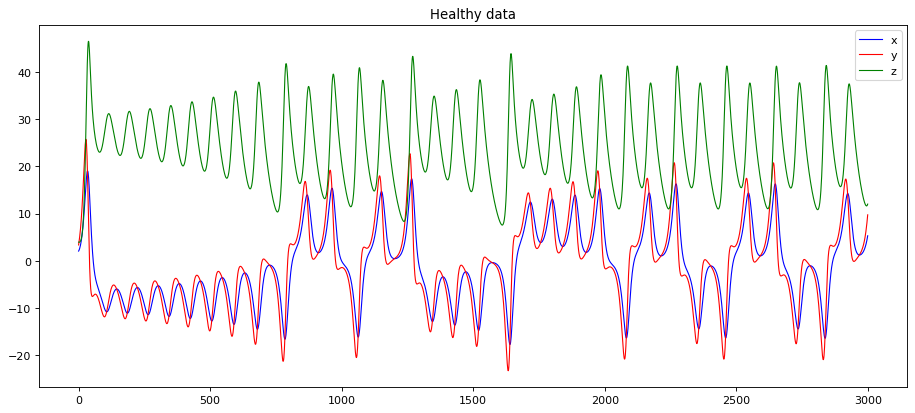

In [4]:
fig, ax = plt.subplots(num=None, figsize=(14, 6), dpi=80, facecolor='w', edgecolor='k')
size = len(data_healthy)
ax.set_title('Healthy data')
ax.plot(range(0,size), data_healthy[:,0], '-', color='blue', animated = True, linewidth=1, label="x")
ax.plot(range(0,size), data_healthy[:,1], '-', color='red', animated = True, linewidth=1, label="y")
ax.plot(range(0,size), data_healthy[:,2], '-', color='green', animated = True, linewidth=1, label="z")
ax.legend()

### - Dados Avariados

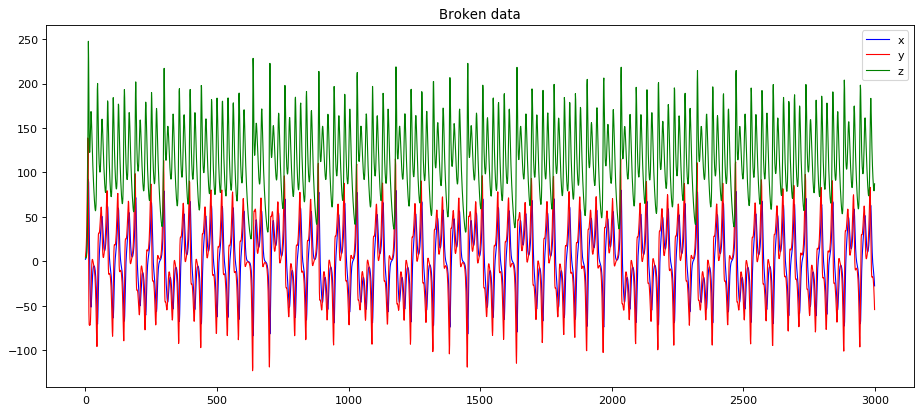

In [5]:
fig, ax = plt.subplots(num=None, figsize=(14, 6), dpi=80, facecolor='w', edgecolor='k')
size = len(data_healthy)
ax.set_title('Broken data')
ax.plot(range(0,size), data_broken[:,0], '-', color='blue', animated = True, linewidth=1, label="x")
ax.plot(range(0,size), data_broken[:,1], '-', color='red', animated = True, linewidth=1, label="y")
ax.plot(range(0,size), data_broken[:,2], '-', color='green', animated = True, linewidth=1, label="z")
ax.legend()

### - FFT dos dados

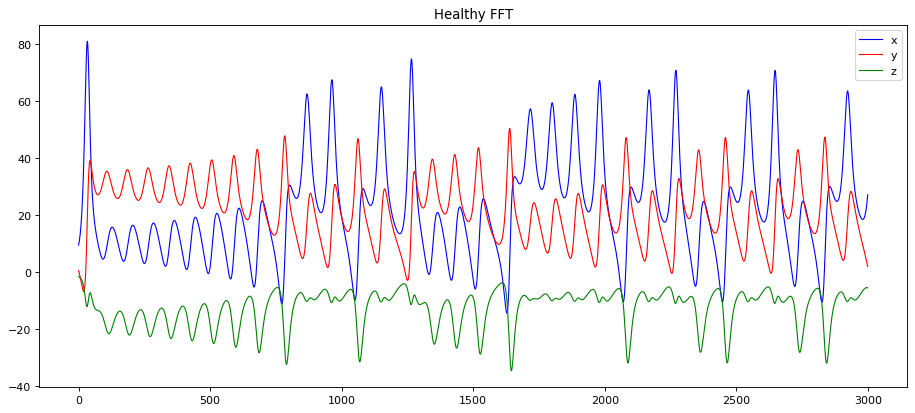

In [6]:
data_healthy_fft = np.fft.fft(data_healthy)

fig, ax = plt.subplots(num=None, figsize=(14, 6), dpi=80, facecolor='w', edgecolor='k')
size = len(data_healthy_fft)
ax.set_title('Healthy FFT')
ax.plot(range(0,size), data_healthy_fft[:,0].real, '-', color='blue', animated = True, linewidth=1, label="x")
ax.plot(range(0,size), data_healthy_fft[:,1].imag, '-', color='red', animated = True, linewidth=1, label="y")
ax.plot(range(0,size), data_healthy_fft[:,2].real, '-', color='green', animated = True, linewidth=1, label="z")
ax.legend()

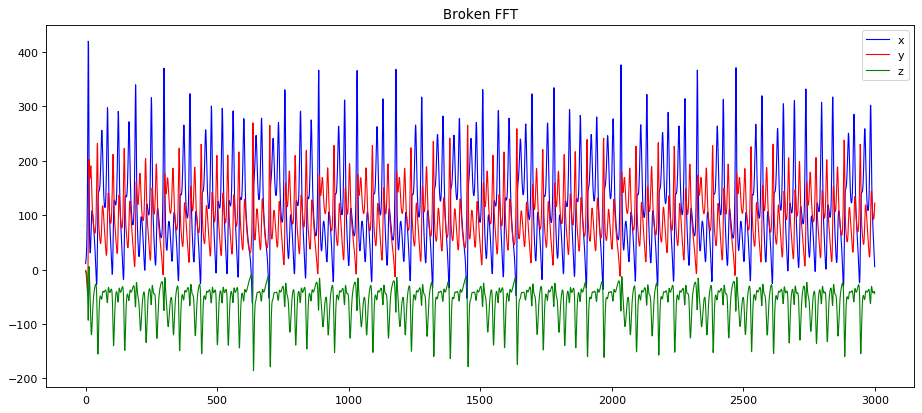

In [7]:
data_broken_fft = np.fft.fft(data_broken)

fig, ax = plt.subplots(num=None, figsize=(14, 6), dpi=80, facecolor='w', edgecolor='k')
size = len(data_healthy_fft)
ax.set_title('Broken FFT')
ax.plot(range(0,size), data_broken_fft[:,0].real, '-', color='blue', animated = True, linewidth=1, label="x")
ax.plot(range(0,size), data_broken_fft[:,1].imag, '-', color='red', animated = True, linewidth=1, label="y")
ax.plot(range(0,size), data_broken_fft[:,2].real, '-', color='green', animated = True, linewidth=1, label="z")
ax.legend()

## Normalização dos dados

In [ ]:
def scaleData(data):
    scaler = MinMaxScaler(feature_range=(0, 1))
    return scaler.fit_transform(data)

In [ ]:
data_healthy_scaled = scaleData(data_healthy)
data_broken_scaled = scaleData(data_broken)

## Formatação dos dados no formato (300,10,3)

In [ ]:
timesteps = 10
dim = 3
samples = 3000
data_healthy_scaled_reshaped = data_healthy_scaled
data_healthy_scaled_reshaped.shape = (int(samples/timesteps),timesteps,dim)

## Gerenciamento das perdas do modelo

In [ ]:
losses = []

def handleLoss(loss):
        global losses
        losses+=[loss]
        print(loss)
        
class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []

    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        handleLoss(logs.get('loss'))

## Definição do modelo com Keras e LSTM

In [ ]:
model = Sequential()
model.add(LSTM(50,input_shape=(timesteps,dim),return_sequences=True))
model.add(LSTM(50,input_shape=(timesteps,dim),return_sequences=True))
model.add(LSTM(50,input_shape=(timesteps,dim),return_sequences=True))
model.add(LSTM(50,input_shape=(timesteps,dim),return_sequences=True))
model.add(LSTM(50,input_shape=(timesteps,dim),return_sequences=True))
model.add(LSTM(50,input_shape=(timesteps,dim),return_sequences=True))
model.add(LSTM(50,input_shape=(timesteps,dim),return_sequences=True))
model.add(LSTM(50,input_shape=(timesteps,dim),return_sequences=True))
model.add(LSTM(50,input_shape=(timesteps,dim),return_sequences=True))
model.add(LSTM(50,input_shape=(timesteps,dim),return_sequences=True))
model.add(LSTM(50,input_shape=(timesteps,dim),return_sequences=True))
model.add(Dense(3))
model.compile(loss='mae', optimizer='adam')

In [1]:
def train(data):
    data.shape = (300, 10, 3)
    model.fit(data, data, epochs=50, batch_size=72, validation_data=(data, data), verbose=1, shuffle=False,
              callbacks=[LossHistory()])
    data.shape = (3000, 3)

def score(data):
    data.shape = (300, 10, 3)
    yhat = model.predict(data)
    yhat.shape = (3000, 3)
    return yhat

## Treinamento do modelo com os dados

In [ ]:
"""
"Train with healthy data"
print("----------------healthy")
for i in range(20):
    
    print (f"{i}", end = " ")
    train(data_healthy_scaled)
    yhat_healthy = score(data_healthy_scaled)
    yhat_broken = score(data_broken_scaled)
    data_healthy_scaled.shape = (3000, 3)
    data_broken_scaled.shape = (3000, 3)
    print()

"Train with broken data"
print ("Broken ")
train(data_broken_scaled)
yhat_healthy = score(data_healthy_scaled)
yhat_broken = score(data_broken_scaled)
data_healthy_scaled.shape = (3000, 3)
data_broken_scaled.shape = (3000, 3)

"Saves the model"
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")

"Losses plot"
fig, ax = plt.subplots(num=None, figsize=(14, 6), dpi=80, facecolor='w', edgecolor='k')
size = len(data_healthy_fft)
ax.set_title("Losses")
ax.plot(range(0,len(losses)), losses, '-', color='blue', animated = True, linewidth=1)
"""

In [ ]:
#Load model
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
#Load weights
loaded_model.load_weights("model.h5")

## Conexão com a rede de gerenciamento IOT da IBM

In [ ]:
options = {"org": "rluizn", "id": "Anoomaly", "auth-method": "apikey", "auth-key": "a-rluizn-lllwueo4ze", "auth-token": "c6thbjGC0hH-I+2cp)"}
client = ibmiotf.application.Client(options)
client.connect()

q = Queue(7000)

def myEventCallback(event):
    sample = event.data
    point = [sample["x"], sample["y"],sample["z"]]
    print(point)
    q.put(point)

client.deviceEventCallback = myEventCallback
# Argumentos: (deviceType, deviceId, eventId, msgFormat)
client.subscribeToDeviceEvents("0.16.2", "lorenz", "osc", "json")

## Definição do treinamento da rede constantemente

In [ ]:
def doNN(data):
    data_scaled = scaleData(data)
    train(data_scaled)
    yhat = score(data_scaled)
    data_scaled.shape = (3000, 3)

# Redefinição do gerenciamento das perdas, com o envio de eventos no iot
def handleLoss(loss):
        myData={'loss' : str(loss)}
        #Argumentos: (deviceType, deviceId, eventId, msgFormat)
        client.publishEvent("0.16.2", "lorenz", "status", "json", myData)

## Tratamento os dados em tempo real

In [ ]:
while True:
    while not q.empty():
        point = q.get()
        try:
            data
            print(data)
        except NameError:
            print("none")
            data = np.array(point)
        else:
            data = np.append(data,point)
            print(f"Size: {data.size}")
        if data.size>=9000:
            data = np.reshape(data,(3000,3))
            print(data)
            doNN(data)
            del data
